## Libraries

In [1038]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


## Data Exploration

In [1039]:
df = pd.read_pickle('../assignment-TL/data/df_bd.pkl')

In [1040]:
# Muestra las primeras 5 filas del dataframe
print(df.head())

          x1        x2  x3  x4   x5   x6  Target
0  1525020.0   2.32277  10   7  310  718     1.0
1   274197.0  19.31960   6  21   29  541     1.0
2   169780.0  12.50540   6   1   62  763     1.0
3    17227.8  16.52660   2  14   45  728     1.0
4   437237.0  32.53740   4  23   22  683     1.0


In [1041]:
# Calcula el número de filas y columnas del dataframe
print("Shape del dataframe:", df.shape)

Shape del dataframe: (385, 7)


In [1042]:
# Muestra el tipo de dato de cada columna
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
x1        float64
x2        float64
x3          int64
x4          int64
x5          int64
x6          int64
Target    float64
dtype: object


In [1043]:
# Chequeamos si hay valores faltantes
print("Missing values por Columna:")
print(df.isnull().sum())

Missing values por Columna:
x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
Target    0
dtype: int64


In [1044]:
# Muestra las estadísticas básicas de las columnas numéricas
print("Basic statistics of the numerical columns:")
print(df.describe())

Basic statistics of the numerical columns:
                 x1          x2          x3          x4           x5  \
count  3.850000e+02  385.000000  385.000000  385.000000   385.000000   
mean   9.461822e+05   25.798971    5.662338   20.740260    80.337662   
std    1.718188e+06   29.385563    5.395818   31.255501   220.640911   
min    7.021610e+03    0.213802    1.000000    0.000000     4.000000   
25%    1.755010e+05    9.088670    3.000000    4.000000    16.000000   
50%    3.511500e+05   16.644800    5.000000    9.000000    35.000000   
75%    9.127680e+05   29.799900    7.000000   22.000000    70.000000   
max    1.466670e+07  235.558000   63.000000  231.000000  3411.000000   

                x6      Target  
count   385.000000  385.000000  
mean    576.779221    0.787013  
std     192.118238    0.409951  
min      44.000000    0.000000  
25%     467.000000    1.000000  
50%     664.000000    1.000000  
75%     714.000000    1.000000  
max    1147.000000    1.000000  


In [1045]:
# Chequea la distribución de la variable target
print("Distribución de la variable target:")
print(df['Target'].value_counts())

Distribución de la variable target:
Target
1.0    303
0.0     82
Name: count, dtype: int64


## Feature Selection

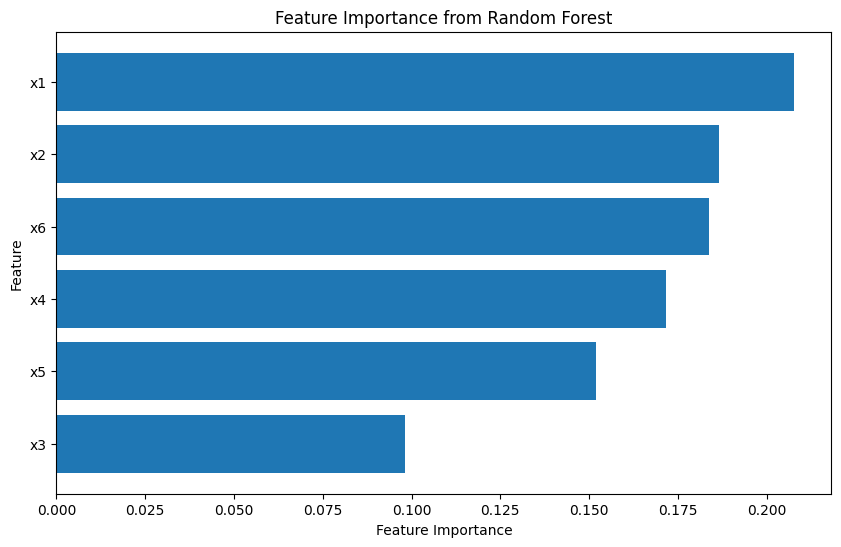

In [1046]:
# Separamos las variables predictoras de la variable target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Dividiendo el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entre un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtenemos la importancia de las variables
importances = rf.feature_importances_

# Obtenemos los nombres de las variables
feature_names = df.columns[:-1]

# Creamos un dataframe con las variables y su importancia
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Ploteamos la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

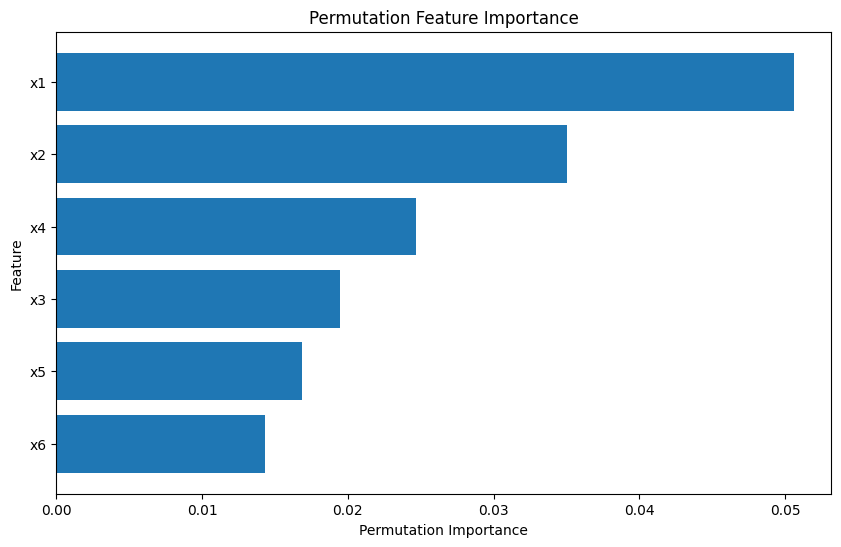

In [1047]:
# Calculate permutation feature importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create a DataFrame for visualization
perm_importances = pd.DataFrame({'feature': feature_names, 'importance': result.importances_mean})
perm_importances = perm_importances.sort_values(by='importance', ascending=False)

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(perm_importances['feature'], perm_importances['importance'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [1048]:
# Creamos una función para calcular el VIF y guardarlo en un DataFrame
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

vif_df = calculate_vif(df.iloc[:, :-1])  # Excluiremos la variable target
print(vif_df)

  feature       VIF
0      x1  1.242173
1      x2  1.860930
2      x3  2.597374
3      x4  1.460679
4      x5  1.410494
5      x6  3.352834


## Data Augmentation

In [1049]:
# 1. SMOTE for synthetic minority over-sampling
def smote_augmentation(X, y):
    sm = SMOTETomek(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res)

X = df.drop('Target', axis=1)
y = df['Target']

X, y = smote_augmentation(X, y)
print('After SMOTE:', X.shape, y.shape)


After SMOTE: (442, 6) (442,)


## Entrenamiento del Modelo

In [1050]:
# Dividimos el dataset en training y testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos las features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1051]:
# Generamos los pesos de clase para balancear el dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0}


In [1052]:


model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[BinaryAccuracy()])

In [1053]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/50
18/18 [==============================] - 1s 11ms/step - loss: 0.7775 - binary_accuracy: 0.5461 - val_loss: 0.7701 - val_binary_accuracy: 0.5634
Epoch 2/50
18/18 [==============================] - 0s 4ms/step - loss: 0.7788 - binary_accuracy: 0.5567 - val_loss: 0.7695 - val_binary_accuracy: 0.6056
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.7586 - binary_accuracy: 0.5567 - val_loss: 0.7730 - val_binary_accuracy: 0.5352
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 0.7585 - binary_accuracy: 0.5674 - val_loss: 0.7723 - val_binary_accuracy: 0.5070
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 0.7396 - binary_accuracy: 0.6064 - val_loss: 0.7734 - val_binary_accuracy: 0.5070
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.7355 - binary_accuracy: 0.6028 - val_loss: 0.7762 - val_binary_accuracy: 0.5211
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.7

In [1054]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
# Predict classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67        45
         1.0       0.67      0.55      0.60        44

    accuracy                           0.64        89
   macro avg       0.64      0.64      0.64        89
weighted avg       0.64      0.64      0.64        89

ROC-AUC Score: 0.6787878787878787


In [1055]:
   #
#  Evaluación del Modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\n")

Accuracy: 0.6404
Precision: 0.6667
Recall: 0.5455
F1 Score: 0.6000




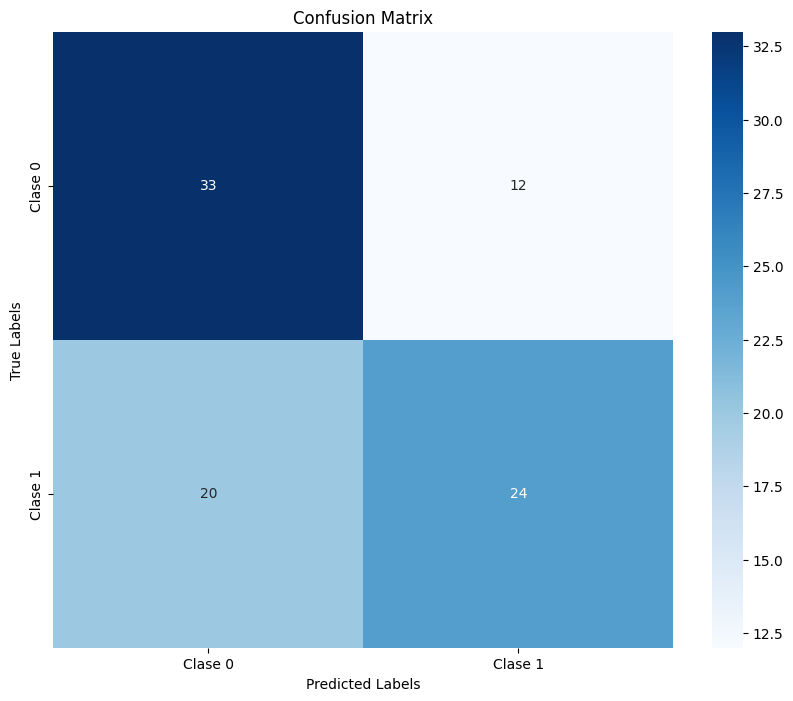

In [1056]:
def print_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Etiquetas de clase (puedes ajustarlas según tu conjunto de datos)
class_labels = ['Clase 0', 'Clase 1']

# Imprimir la matriz de confusión
print_confusion_matrix(confusion_matrix(y_test, y_pred), labels=class_labels)